# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [3]:
set_config(display='diagram')

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

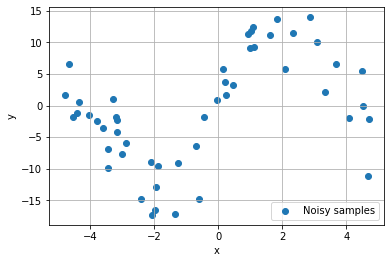

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

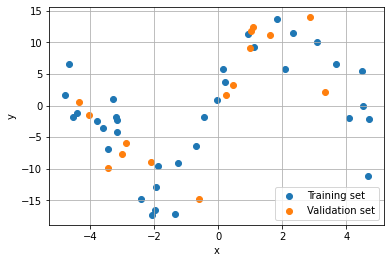

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [8]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [9]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [10]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

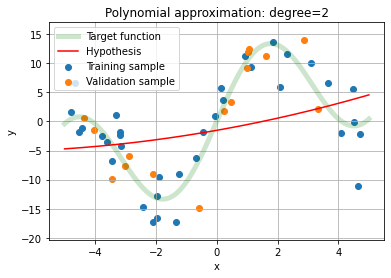

In [11]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

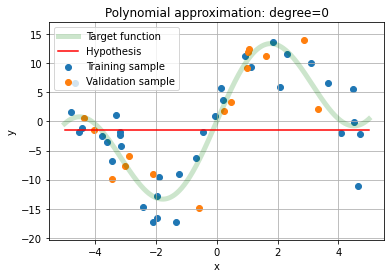

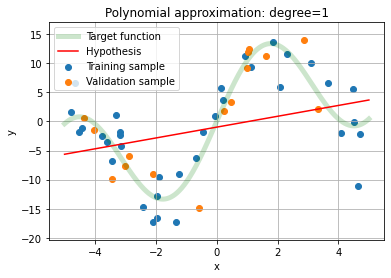

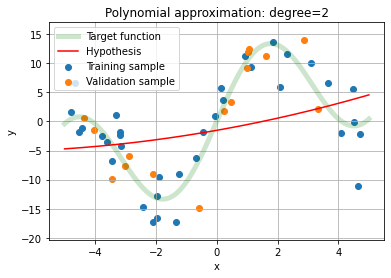

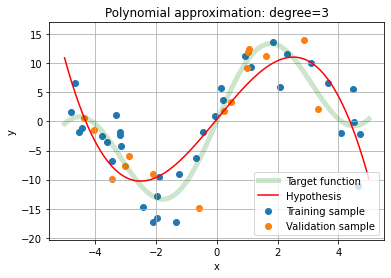

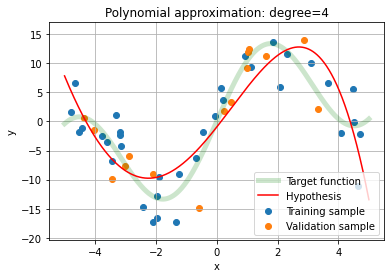

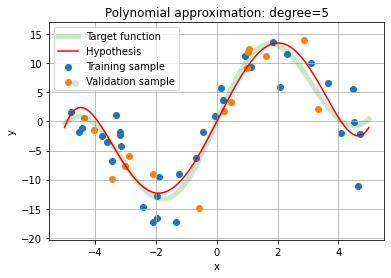

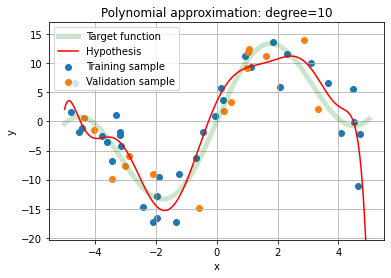

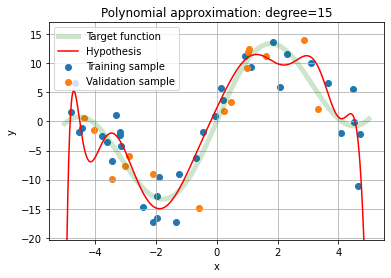

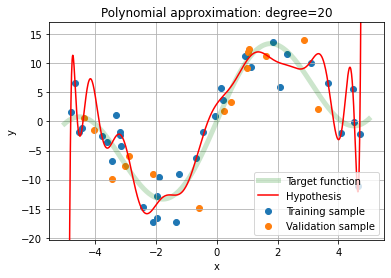

In [12]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

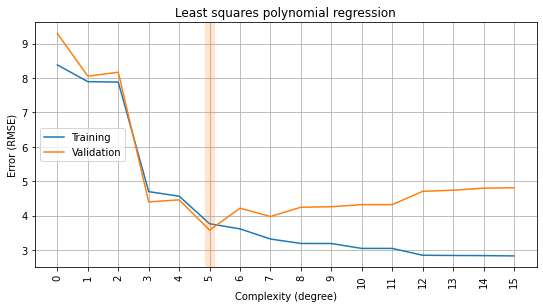

In [13]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [14]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

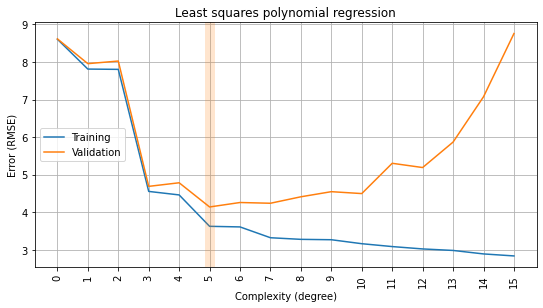

In [15]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [16]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

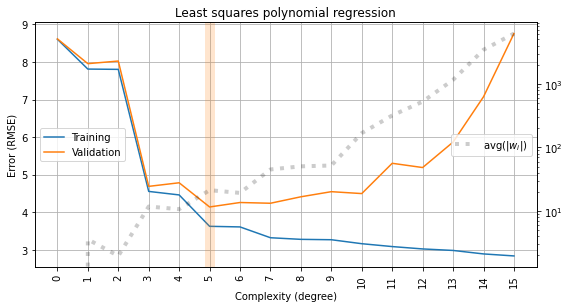

In [17]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

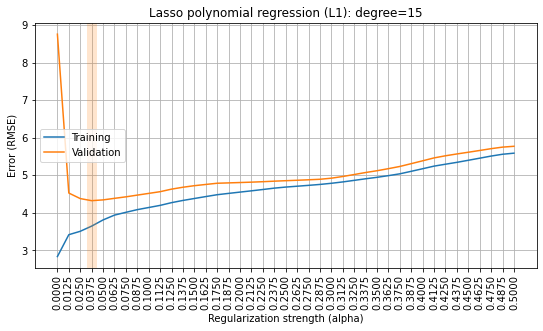

In [18]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

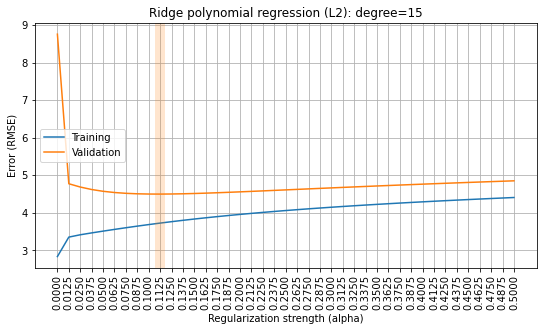

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

**WARNING!**

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you **must collect all features together** (those which were used to generate polynomials and the rest).

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [20]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [21]:
# Display features and target values

print('Number of features in the dataset: ', X_diabetes.shape[1])
X_diabetes.join(y_diabetes).head()

Number of features in the dataset:  10


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

In [22]:
# import required libraries and methods

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_percentage_error as mapr
from sklearn import linear_model

In [23]:
# Split the data into training and test subsets with 75 to 25 ratio respectively

x_train, x_test, y_train, y_test = train_test_split(X_diabetes, y_diabetes, test_size = 0.25, random_state = 42)

In [24]:
# Create polymonial features with degree of 4

polyn_features_train = PolynomialFeatures(degree = 3, include_bias = False).fit_transform(x_train)
print('Polynomial features shape: \n', polyn_features_train.shape)

Polynomial features shape: 
 (331, 285)


In [25]:
# Create linear regression model and fit the data into it

linear_reg = LinearRegression()
linear_reg.fit(polyn_features_train, y_train)

LinearRegression()

In [26]:
# Evaluate the model performance on training data

y_pred_train = linear_reg.predict(polyn_features_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print('Square root of Mean squared error on training set:', rmse_train)

Square root of Mean squared error on training set: 22.626119762902654


In [27]:
# Evaluate the model performance on training data

y_pred_test = linear_reg.predict(PolynomialFeatures(degree = 3, include_bias = False).fit_transform(x_test))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print('Square root of Mean squared error on training set:', rmse_test)

Square root of Mean squared error on training set: 14261.618771914333


The error on the test set is extremely high. Moreover, the difference between performance of the model on training and test data set is radical. Thus, the overfitting is high. The model should be regularized or the number of features should be reduced. At first find relationship between polynomial degree and model error.

In [28]:
# Create a function, which returns errors for training and test sets depending on polynomial degree
# Input variables: n - number of degrees, error - type of the error being evaluated

def polyn_assess(n = 7, error = mapr, x_train = x_train, y_train = y_train, x_test = x_test, y_test = y_test):
    degrees = np.arange(1, n + 1)

    error_train = []
    error_test = []
    
    for i in degrees:
        polyn_features_train = PolynomialFeatures(degree = i, include_bias = False).fit_transform(x_train)
        linear_reg = LinearRegression()
        linear_reg.fit(polyn_features_train, y_train)
        y_pred_i_train = linear_reg.predict(polyn_features_train)
        error_train.append(error(y_train, y_pred_i_train))
    
        polyn_features_test = PolynomialFeatures(degree = i, include_bias = False).fit_transform(x_test)
        
        y_pred_i_test = linear_reg.predict(polyn_features_test)
        error_test.append(error(y_test, y_pred_i_test))
    return degrees, error_train, error_test

In [29]:
degrees, error_train, error_test = polyn_assess(n = 12)

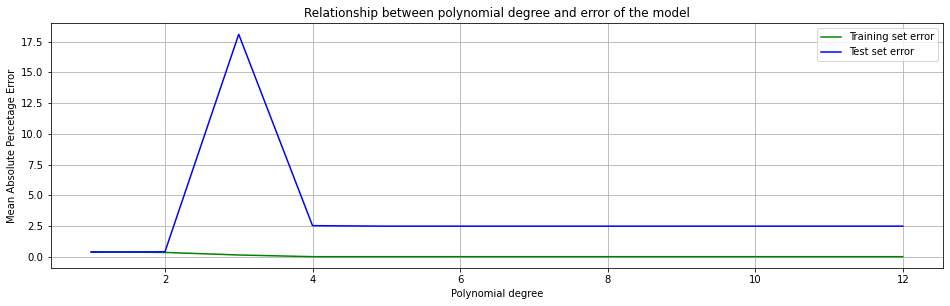

In [30]:
plt.figure(figsize=(16, 4.5))
plt.plot(degrees, error_train, color = 'green')
plt.plot(degrees, error_test, color = 'blue')
plt.grid(True)
plt.xlabel('Polynomial degree')
plt.ylabel('Mean Absolute Percetage Error')
plt.title('Relationship between polynomial degree and error of the model')
plt.legend(['Training set error', 'Test set error'])
plt.show()

Adding any polymonial degree to the all features of the model causes overfitting because the number of features becomes too high or even greater than the number of training axamples. Thus, select one feature or a set of features to create polinomial features. To determine what features can be chosen, look at relationship between each feature and the target variable

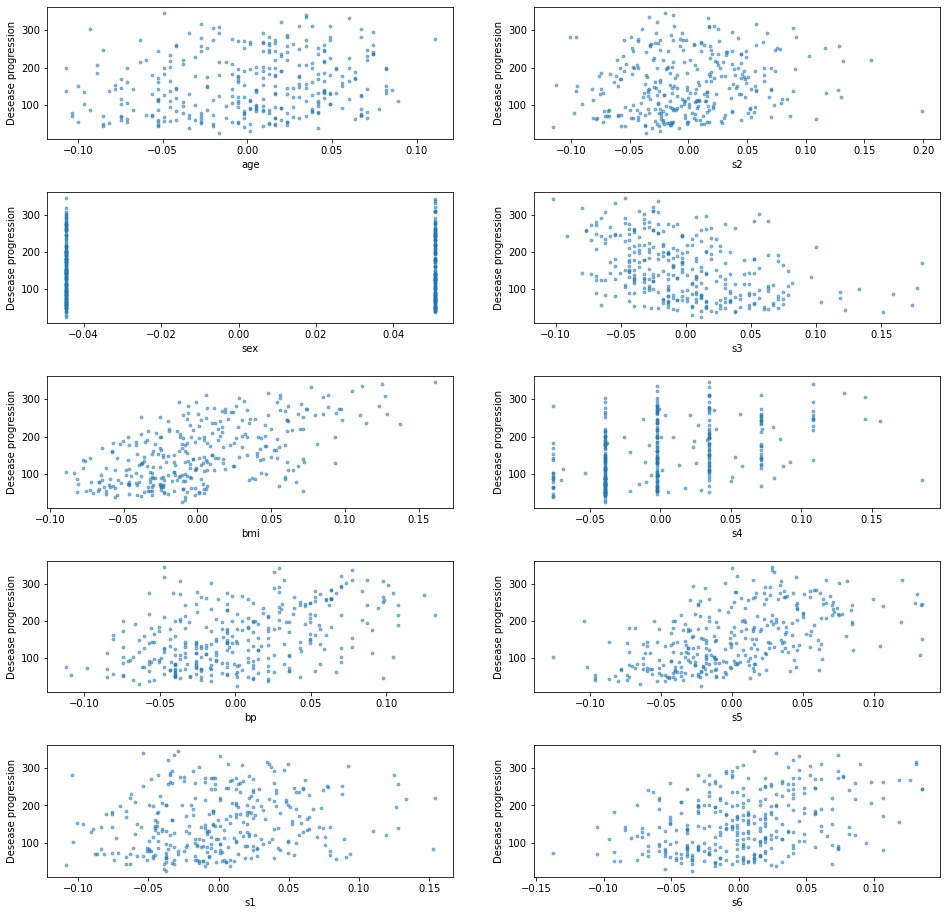

In [31]:
# Explore dependency of the target variable from each feature

figure, axs = plt.subplots(5, 2, figsize = (16, 16))
figure.subplots_adjust(hspace = 0.4)  

for i in range(x_train.shape[1]):
    j = i
    k = 0
    if j > 4:
        j = i - 5
        k = 1
    axs[j, k].scatter(x_train.iloc[:, i], y_train.iloc[:, 0], alpha = 0.5, s = 8)
    axs[j, k].set_xlabel(x_train.columns.to_list()[i])
    axs[j, k].set_ylabel('Desease progression')
plt.show()

In [32]:
# Create a function which adds polinomial features for the set of features

features = ['s3', 'bmi', 's5']

def regression(feature = features, n = 30, error = mapr, x_train = x_train, x_test = x_test, y_train = y_train, y_test = y_test):
    
    degrees = np.arange(1, n + 1)

    error_train = []
    error_test = []

    feature_train = x_train[feature].to_numpy()
    feature_test = x_test[feature].to_numpy()

    for i in degrees:  
        
        polyn_train = PolynomialFeatures(degree = i, include_bias = False).fit_transform(feature_train)  
        polyn_test = PolynomialFeatures(degree = i, include_bias = False).fit_transform(feature_test)

        x_train_data = np.hstack((x_train.drop(columns = feature).to_numpy(), polyn_train))
        x_test_data = np.hstack((x_test.drop(columns = feature).to_numpy(), polyn_test))
        
        linear_reg = LinearRegression()
        linear_reg.fit(x_train_data, y_train)
        y_pred_train = linear_reg.predict(x_train_data)
        error_train.append(error(y_train, y_pred_train))
           
        y_pred_test = linear_reg.predict(x_test_data)
        error_test.append(error(y_test, y_pred_test))
    
    
    return degrees, error_train, error_test

In [33]:
degrees, error_train, error_test = regression(n = 20)

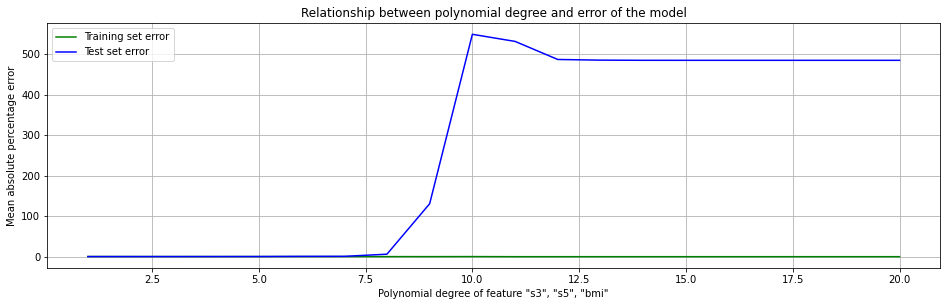

In [34]:
plt.figure(figsize=(16, 4.5))
plt.plot(degrees, error_train, color = 'green')
plt.plot(degrees, error_test, color = 'blue')
plt.grid(True)
plt.xlabel('Polynomial degree of feature "s3", "s5", "bmi"')
plt.ylabel('Mean absolute percentage error')
plt.title('Relationship between polynomial degree and error of the model')
plt.legend(['Training set error', 'Test set error'])
plt.show()

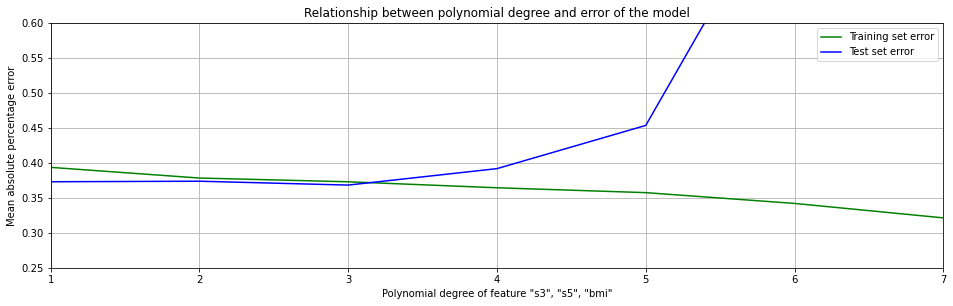

In [35]:
plt.figure(figsize=(16, 4.5))
plt.plot(degrees, error_train, color = 'green')
plt.plot(degrees, error_test, color = 'blue')
plt.xlim([1, 7])
plt.ylim([0.25, 0.6])
plt.grid(True)
plt.xlabel('Polynomial degree of feature "s3", "s5", "bmi"')
plt.ylabel('Mean absolute percentage error')
plt.title('Relationship between polynomial degree and error of the model')
plt.legend(['Training set error', 'Test set error'])
plt.show()

Two last graphs shows the affect of polynomial features introduction (for features - body mass index, high-density lipoproteins, possibly log of serum triglycerides level) on model error. The diagrams reveals that model performance on training and test sets becomes better with polynomial degree up to 3. With polymonial degree higher than 3 test set error rises significantly, whereas training set error continues to drop gradually. This means that model with polynomial features higher than 3 experiences overfitting. Regularization should be applied to such model to get rid of overfitting and improve model performance.

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [36]:
# Create linear regression with L1 regularization

features = ['s3', 'bmi', 's5']
original_features = x_test.drop(columns = features).columns.to_list()
ALPHAS[0] += 0.0001

def l1_regression(feature = features, error = mapr, x_train = x_train, x_test = x_test, y_train = y_train, y_test = y_test):
    error_train = []
    error_test = []
    coefficients = []
    
    feature_train = x_train[feature].to_numpy()
    feature_test = x_test[feature].to_numpy()

    for i in ALPHAS:
        
        polyn_train = PolynomialFeatures(degree = 15, include_bias = False).fit_transform(feature_train)  
        polyn_test = PolynomialFeatures(degree = 15, include_bias = False).fit_transform(feature_test)

        x_train_data = np.hstack((x_train.drop(columns = feature).to_numpy(), polyn_train))
        x_test_data = np.hstack((x_test.drop(columns = feature).to_numpy(), polyn_test))
        
        l1_reg = linear_model.Lasso(alpha = i)
        l1_reg.fit(x_train_data, y_train)
        coefficients.append(l1_reg.coef_)
        y_pred_train = l1_reg.predict(x_train_data)
        error_train.append(error(y_train, y_pred_train))
           
        y_pred_test = l1_reg.predict(x_test_data)
        error_test.append(error(y_test, y_pred_test))
    
    
    return error_train, error_test, coefficients

In [37]:
l1_error_train, l1_error_test, l1_coeff = l1_regression()

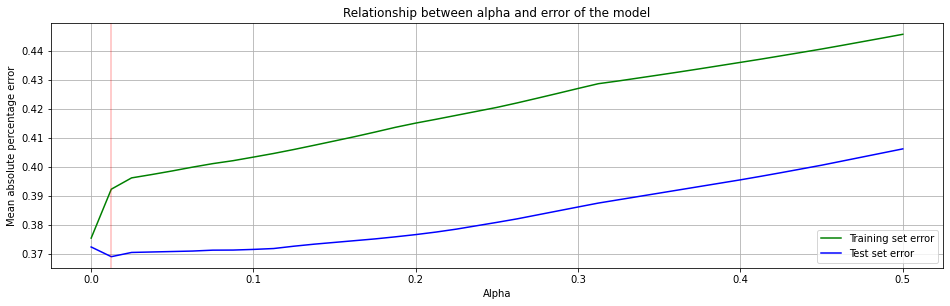

Optimum alpha value is:  0.0125
Minimum error on set set:  0.36900394559896205


In [38]:
# Let's look at relationship between alpha values and model error

plt.figure(figsize=(16, 4.5))
plt.plot(ALPHAS, l1_error_train, color = 'green')
plt.plot(ALPHAS, l1_error_test, color = 'blue')
plt.axvline(ALPHAS[np.argmin(l1_error_test)], color='red', lw=2, alpha=0.2)
plt.grid(True)
plt.xlabel('Alpha')
plt.ylabel('Mean absolute percentage error')
plt.title('Relationship between alpha and error of the model')
plt.legend(['Training set error', 'Test set error'])
plt.show()
print('Optimum alpha value is: ', ALPHAS[np.argmin(l1_error_test)])
print('Minimum error on set set: ', min(l1_error_test))

Model performance gradually gets worse with alpha values more than 0.0125 on both training and test sets. 

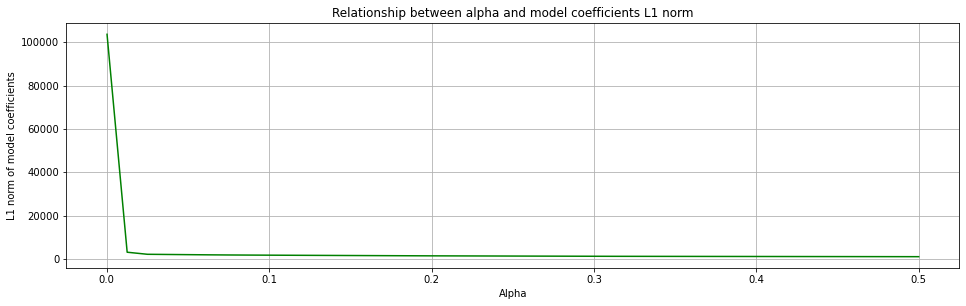

In [39]:
# Let's look at model coefficients with different values of alpha, calculate L1 norm of the coefficients

l1_coeff = np.array(l1_coeff)
l1_norm_coeff = np.sum(abs(l1_coeff), axis = 1)

plt.figure(figsize=(16, 4.5))
plt.plot(ALPHAS, l1_norm_coeff, color = 'green')
#plt.ylim([-0.25, 0.25])
plt.grid(True)
plt.xlabel('Alpha')
plt.ylabel('L1 norm of model coefficients')
plt.title('Relationship between alpha and model coefficients L1 norm')
plt.show()

#### L2

In [40]:
# Create linear regression with L2 regularization

features = ['s3', 'bmi', 's5']

def l2_regression(feature = features, error = mapr, x_train = x_train, x_test = x_test, y_train = y_train, y_test = y_test):
    error_train = []
    error_test = []
    coefficients = []
    
    feature_train = x_train[feature].to_numpy()
    feature_test = x_test[feature].to_numpy()

    for i in ALPHAS:  
        
        polyn_train = PolynomialFeatures(degree = 15, include_bias = False).fit(feature_train)
        features_polyn = polyn_train.get_feature_names(x_train[feature].columns)
        polyn_train = polyn_train.transform(feature_train)
        polyn_test = PolynomialFeatures(degree = 15, include_bias = False).fit_transform(feature_test)

        x_train_data = np.hstack((x_train.drop(columns = feature).to_numpy(), polyn_train))
        x_test_data = np.hstack((x_test.drop(columns = feature).to_numpy(), polyn_test))
        
        l2_reg = linear_model.Ridge(alpha = i)
        l2_reg.fit(x_train_data, y_train)
        coefficients.append(l2_reg.coef_)
        y_pred_train = l2_reg.predict(x_train_data)
        error_train.append(error(y_train, y_pred_train))
           
        y_pred_test = l2_reg.predict(x_test_data)
        error_test.append(error(y_test, y_pred_test))
    
    
    return error_train, error_test, coefficients, features_polyn

In [41]:
l2_error_train, l2_error_test, l2_coeff, features_polyn = l2_regression()

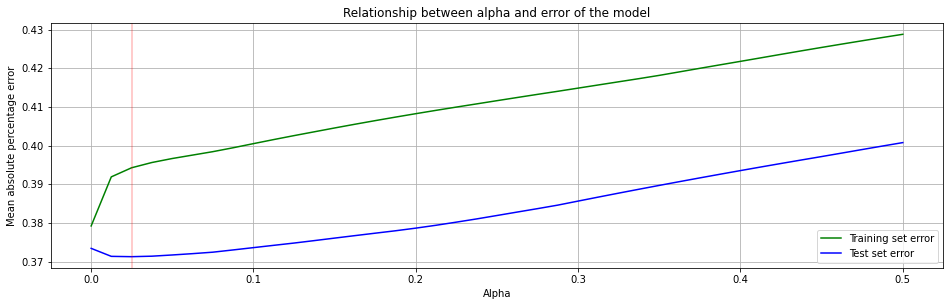

Optimum alpha value is:  0.025
Minimum error on test set:  0.3712503529989178


In [42]:
# Let's look at relationship between alpha values and model error

plt.figure(figsize=(16, 4.5))
plt.plot(ALPHAS, l2_error_train, color = 'green')
plt.plot(ALPHAS, l2_error_test, color = 'blue')
plt.axvline(ALPHAS[np.argmin(l2_error_test)], color='red', lw=2, alpha=0.2)
plt.grid(True)
plt.xlabel('Alpha')
plt.ylabel('Mean absolute percentage error')
plt.title('Relationship between alpha and error of the model')
plt.legend(['Training set error', 'Test set error'])
plt.show()
print('Optimum alpha value is: ', ALPHAS[np.argmin(l2_error_test)])
print('Minimum error on test set: ', min(l2_error_test))

Model performance gradually gets worse with alpha values more than 0.025 on both training and test sets. 

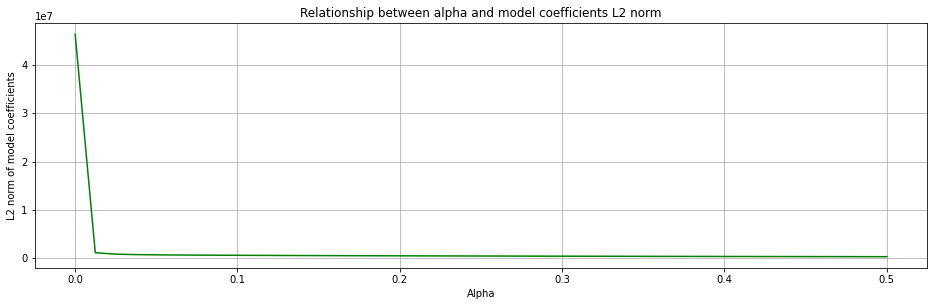

In [43]:
# Let's look at model coefficients with different values of alpha, calculate L1 norm of the coefficients

l2_coeff = np.array(l2_coeff).reshape((len(ALPHAS), -1))
l2_norm_coeff = np.sum(l2_coeff**2, axis = 1)

plt.figure(figsize=(16, 4.5))
plt.plot(ALPHAS, l2_norm_coeff, color = 'green')
plt.grid(True)
plt.xlabel('Alpha')
plt.ylabel('L2 norm of model coefficients')
plt.title('Relationship between alpha and model coefficients L2 norm')
plt.show()

#### Summary

In [44]:
# The same model with 15 degree polynomial but without regularization shows the following errors

print('Training set error of the model without regularization:', error_train[15]) 
print('Test set error of the model without regularization:', error_test[15])

Training set error of the model without regularization: 0.08515521334849281
Test set error of the model without regularization: 484.3454755424244


In [45]:
# Create comparative table

data = {'Model without regularization': [error_train[15], error_test[15]],
        'Model with L1 regularization': [l1_error_train[np.argmin(l1_error_test)], min(l1_error_test)], 
        'Model with L2 regularization': [l2_error_train[np.argmin(l2_error_test)], min(l2_error_test)]}
comparizon = pd.DataFrame(data = data, index = ['Error on training set', 'Error on test set'])
comparizon

,Model without regularization,Model with L1 regularization,Model with L2 regularization
Error on training set,0.085155,0.392247,0.394277
Error on test set,484.345476,0.369004,0.371250


In [46]:
print('Difference between test set errors of L1 and L2 regularizations:', 
      100 * round(abs(min(l1_error_test) - min(l2_error_test))/ min(l1_error_test), 4), '%')

Difference between test set errors of L1 and L2 regularizations: 0.61 %


Model without regularization is extremely overfitted, since the difference between train and test set errors is drastic. We can achive the best performance on test sets using the model with L1 (Lasso) regularization. Lasso model best performance can be explained by the great amount of the collinear features created as a result of polynomial features introduction. The model probably has had a lot of redundant features, which were sero out with the help of L1 regularization. Ridge model also shows good results of the model performance on test set.

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [47]:
# Take coefficients from the created before model 
# Check which weights are non zeros and find corresponding features and weights

weights = l1_coeff[int(np.where(ALPHAS == ALPHAS[np.argmin(l1_error_test)])[0])]

non_zeros = np.where(weights != 0)
non_zeros = non_zeros[0]

all_features = original_features + features_polyn
non_zero_features = [all_features[i] for i in non_zeros]
non_zero_weights = [round(weights[i], 2) for i in non_zeros]

print('Total number of features: ', len(weights))
print('Number of non zero weights in Lasso model:', len(non_zeros))
print('Number of zero weights in Lasso model:', len(weights) - len(non_zeros))

data = [non_zero_features, non_zero_weights]
features_weights = pd.DataFrame(data = data, index = ['Non zero features in dataset', 'Weights of non zero features'])
features_weights

Total number of features:  822
Number of non zero weights in Lasso model: 11
Number of zero weights in Lasso model: 811


,0,1,2,3,4,5,6,7,8,9,10
Non zero features in dataset,age,sex,bp,s1,s2,s4,s6,s3,bmi,s5,bmi^2
Weights of non zero features,54.94,-227.77,373.36,-374.66,94.65,186.36,28.51,-118.49,514.94,497.3,694.47


#### L2

In [48]:
# Take coefficients from the created before model 
# Check which weights are non zeros and find corresponding features and weights

weights = l2_coeff[int(np.where(ALPHAS == ALPHAS[np.argmin(l2_error_test)])[0])]

non_zeros = np.where(weights != 0)
non_zeros = non_zeros[0]

all_features = original_features + features_polyn
non_zero_features = [all_features[i] for i in non_zeros]
non_zero_weights = [round(weights[i], 2) for i in non_zeros]

print('Total number of features: ', len(weights))
print('Number of non zero weights in Ridge model:', len(non_zeros))
print('Number of zero weights in Ridge model:', len(weights) - len(non_zeros))

Total number of features:  822
Number of non zero weights in Ridge model: 822
Number of zero weights in Ridge model: 0


#### Summary

As shown above, in Ridge model weights for all features are non-zero. Whereas, Lasso model performs feature selection by zeroing out 811 redundant features and remaining 11 important features. Thus, Lasso model indeed is handy for the models with collinear features. Among the features considered eminent by Lasso model are all 10 original features and only 1 created feature - bmi^2. It can be concluded that introduction of polynomial features wasn't so useful for the model performance, on the contrary, it significantly reduced training speed.

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [49]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


#### Perform train test split of the dataset

In [50]:
x_train, x_test, y_train, y_test = train_test_split(X_hw, y_hw, test_size=0.25, random_state=42)

#### Scale the features

In [51]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

#### L1

In [52]:
# Create the Lasso model on the original (not scaled) dataset

l1 = linear_model.Lasso()
l1.fit(x_train, y_train)
y_pred_train = l1.predict(x_train)
y_pred_test = l1.predict(x_test)
l1_train_error = np.sqrt(mse(y_pred_train, y_train))
l1_test_error = np.sqrt(mse(y_pred_test, y_test))

In [53]:
# Create the Lasso model on the scaled dataset

l1_scaled = linear_model.Lasso()
l1_scaled.fit(x_train_scaled, y_train)
y_pred_scaled_train = l1_scaled.predict(x_train_scaled)
y_pred_scaled_test = l1_scaled.predict(x_test_scaled)
l1_scaled_train_error = np.sqrt(mse(y_pred_scaled_train, y_train))
l1_scaled_test_error = np.sqrt(mse(y_pred_scaled_test, y_test))

In [54]:
# Create comparative table

data = {'Lasso model with non-scaled features': [l1_train_error, l1_test_error], 
        'Lasso model with scaled features': [l1_scaled_train_error, l1_scaled_test_error]}
l1_comparizon = pd.DataFrame(data = data, index = ['Error on training set', 'Error on test set'])
l1_difference = pd.DataFrame(data = {'Difference in percentage': [(100 * (l1_train_error - l1_scaled_train_error) / l1_train_error), 
                                     (100 * (l1_test_error - l1_scaled_test_error) / l1_test_error)]},
                            index = ['Error on training set', 'Error on test set'])
l1_comparizon.join(l1_difference)

,Lasso model with non-scaled features,Lasso model with scaled features,Difference in percentage
Error on training set,6.539320,5.278916,19.274242
Error on test set,6.550706,4.263178,34.920325


The differences in errors of the Lasso model with scaled features and non-scaled features are 19.3% and 34.9% for training set and test set, respectively.

#### L2

In [55]:
# Create the Lasso model on the original (not scaled) dataset

l2 = linear_model.Ridge()
l2.fit(x_train, y_train)
y_pred_train = l2.predict(x_train)
y_pred_test = l2.predict(x_test)
l2_train_error = np.sqrt(mse(y_pred_train, y_train))
l2_test_error = np.sqrt(mse(y_pred_test, y_test))

In [56]:
# Create the Lasso model on the scaled dataset

l2_scaled = linear_model.Ridge()
l2_scaled.fit(x_train_scaled, y_train)
y_pred_scaled_train = l2_scaled.predict(x_train_scaled)
y_pred_scaled_test = l2_scaled.predict(x_test_scaled)
l2_scaled_train_error = np.sqrt(mse(y_pred_scaled_train, y_train))
l2_scaled_test_error = np.sqrt(mse(y_pred_scaled_test, y_test))

In [57]:
# Create comparative table

data = {'Ridge model with non-scaled features': [l2_train_error, l2_test_error], 
        'Ridge model with scaled features': [l2_scaled_train_error, l2_scaled_test_error]}
l2_comparizon = pd.DataFrame(data = data, index = ['Error on training set', 'Error on test set'])
l2_difference = pd.DataFrame(data = {'Difference in percentage': [(100 * (l2_train_error - l2_scaled_train_error) / l2_train_error), 
                                     (100 * (l2_test_error - l2_scaled_test_error) / l2_test_error)]},
                            index = ['Error on training set', 'Error on test set'])
l2_comparizon.join(l2_difference)

,Ridge model with non-scaled features,Ridge model with scaled features,Difference in percentage
Error on training set,6.410867,4.143131,35.373314
Error on test set,6.454887,4.348862,32.626835


The differences in errors of the Ridge model with scaled features and non-scaled features are 35.4% and 32.6% for training set and test set, respectively.

#### Summary



In [58]:
l1_comparizon.join(l2_comparizon)

,Lasso model with non-scaled features,Lasso model with scaled features,Ridge model with non-scaled features,Ridge model with scaled features
Error on training set,6.539320,5.278916,6.410867,4.143131
Error on test set,6.550706,4.263178,6.454887,4.348862


Based on the above table, it can be concluded that features scaling considerably improves model performance and reduces model error. 

In general, normalization (features scaling) significantly improves model convergance. It is particularly important for models with regularization because these models aimed at reducing weights values, which is hard to achieve with features on different scales. Features normalization facilitates penalties induced by regularization to distribute more uniformly among all features. Thus, perform features scaling is vital for the models with regularization.